# Neural Network from Scratch
Code modified from https://github.com/adventuresinML/adventures-in-ml-code/blob/master/neural_network_tutorial.py

The notation in this website is almost the same as the notation we are using in class.  Instead of $a$ the author uses $h$, and instead of $N$, the author uses $m$. (I have modified the code below to use $a$ and $N$.)

Please read about this implementation starting at page 27 from the website listed above.

## The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [252]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import copy
from itertools import permutations


## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

In [253]:
# After completing the code in this code cell, run this code cell before moving further.
names =[
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
    'restecg',  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

# TODO - write the pandas command to read the csv file into a dataframe df - 5 points
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
                 header = None, names = names, na_values = '?')

df = df.dropna()
# print(df.shape)
# print(df.shape)

x=np.array(df.iloc[:,0:13])
y=np.array(df.iloc[:,13:14])

#The goal is to distinguish the presence from non-presense 
for i in range(len(y)):
    if(y[i]>0):
        y[i] = 1
#print(y)

# print(x.shape)
# print(y.shape)

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [254]:
X_scale = StandardScaler()
X = X_scale.fit_transform(x)

# X_orig = copy.deepcopy(X)
# y_orig = copy.deepcopy(y)

X[0,:] # Looking the new features after scaling
#print(X.shape[1])

array([ 0.93618065,  0.69109474, -2.24062879,  0.75038004, -0.27644339,
        2.43042728,  1.01019851,  0.01749443, -0.69641941,  1.06896529,
        2.26414539, -0.72197605,  0.65587737])

## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [255]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#print(y_test)

## 3) Setting up the output layer

### One hot encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.

In [256]:
# def convert_y_to_vect(y):
#     y_vect = np.zeros((len(y), 10))
#     for i in range(len(y)):
#         y_vect[i, y[i]] = 1
#     return y_vect

Converting the training and test targets to vectors 

In [257]:
# convert digits to vectors
# y_v_train = convert_y_to_vect(y_train)
# y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [258]:
# print(y_train[0:4])
# print(y_v_train[0:4])

## 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [259]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))



# def f(z):
#     z = copy.deepcopy(z)
    
#     for i in range(z.size):
#         if (z[i] <0):
#             z[i] = 0

#     return z


# def f_deriv(z):
#     z = copy.deepcopy(z)
    
#     for i in range(z.size):
#         if (z[i] <0):
#             z[i] = 0
#         else:
#             z[i] = 1
            
#     return z

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [260]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [261]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [262]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [263]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

## The Back Propagation Algorithm


In [316]:
# l=1, input layer

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.5, lamb=0):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    
    
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        # clean derivative of Ws, since its different every time    
        tri_W, tri_b = init_tri_values(nn_structure)
        
        avg_cost = 0
        
        # for every training sample set
        
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                # last/output layer
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    #Remember that J/W_l = delta[l+1!!!]*a[l]
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # Since tri W_l = sum(J/w^l) for all xs --> J/w = delta_l+1 * a_l     
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
                    
        # this entire for i in N loop above is updating the  deri. of all W_ls
                    
        # perform the gradient descent step for the weights in EACH LAYER! 
        for l in range(len(nn_structure) - 1, 0, -1):
            # wl and tri_W[l] are both 1D array/vectors
            W[l] += -alpha * (1.0/N * tri_W[l] + lamb*W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    #print(avg_cost_func)
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers, threshold):
    N = X.shape[0]
    y = np.zeros((N,))
    
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        if(a[n_layers] > threshold):
            y[i] = 1
        else:
            y[i] = 0         
    return y

def predict_yhat(W, b, X, n_layers, threshold):
    N = X.shape[0]
    y = np.zeros((N,))
    
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        if(a[n_layers] > threshold):
            y[i] = 1
        else:
            y[i] = 0         
    return y



## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [314]:
#input layer, 1 hidden layer, 1 output


# train the NN

acc_300 = []
acc_600 = []

def main(n_neuro, lambs, num_iter=3000):
    acc_test = []
    acc_train = []
    nn_structure = [13, 1]
    nn_structure.insert(1,n_neuro)
    
    for i in range(len(lambs)):
        W, b, avg_cost_func = train_nn(nn_structure, X_train, y_train, num_iter, lambs[i])

#         plt.plot(avg_cost_func)
#         plt.ylabel('Average J')
#         plt.xlabel('Iteration number')
#         plt.show()
        y_hat =  predict_yhat(W, b, X_train, 3, 0.5)
        y_pred = predict_y(W, b, X_test, 3, 0.5)
        
        print('Training accuracy is {}%'.format(accuracy_score(y_train, y_hat) * 100))
        print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
        
        acc_train.append([lambs[i],accuracy_score(y_train, y_hat)])
        acc_test.append([lambs[i],accuracy_score(y_test, y_pred)])
    
    return acc_train, acc_test

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


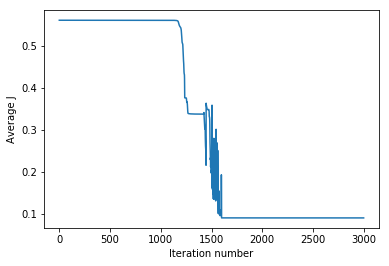

Prediction accuracy is 78.99159663865547%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


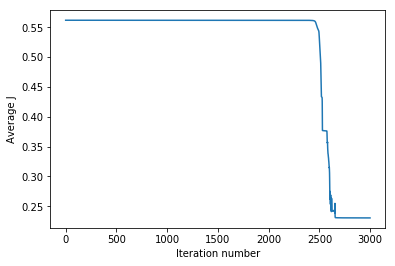

Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


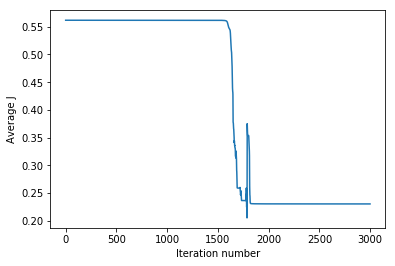

Prediction accuracy is 78.99159663865547%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


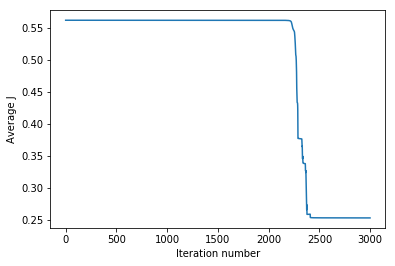

Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


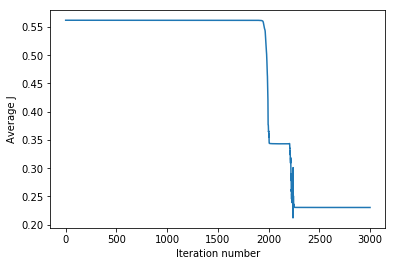

Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


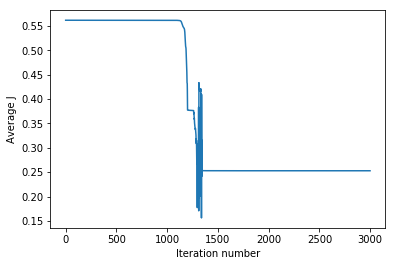

Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


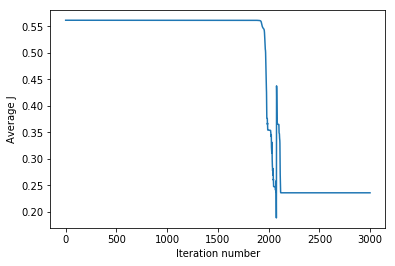

Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


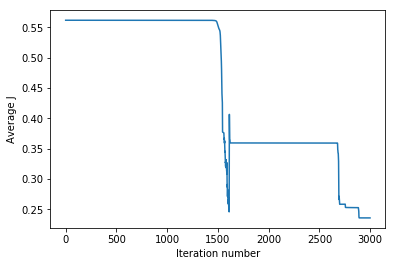

Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


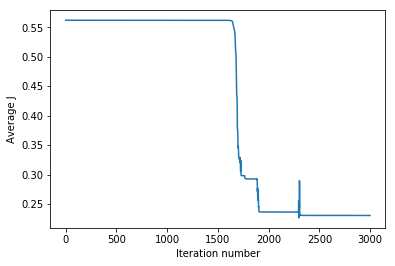

Prediction accuracy is 75.63025210084034%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


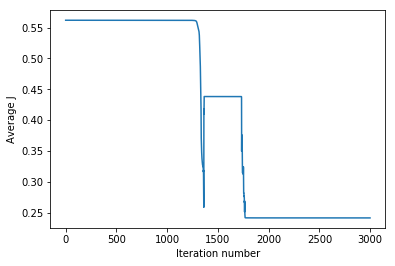

Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


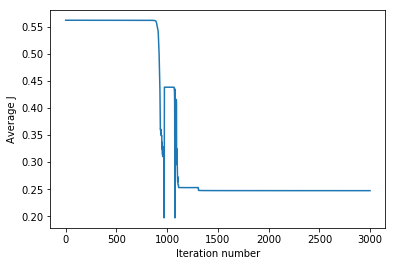

Prediction accuracy is 77.31092436974791%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


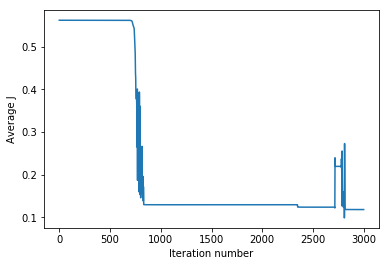

Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


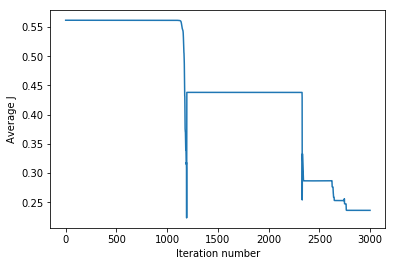

Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


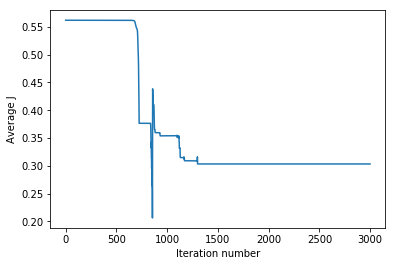

Prediction accuracy is 75.63025210084034%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


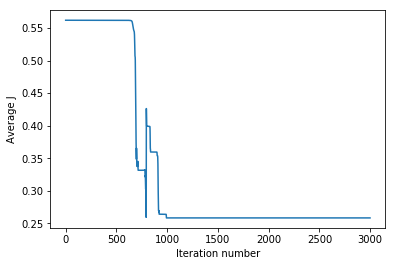

Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


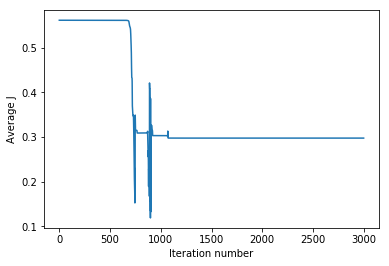

Prediction accuracy is 73.94957983193278%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


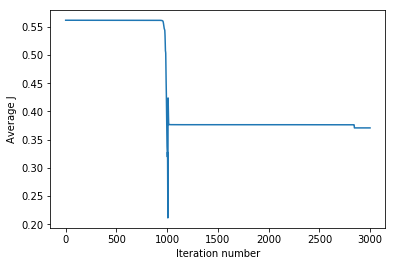

Prediction accuracy is 71.42857142857143%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


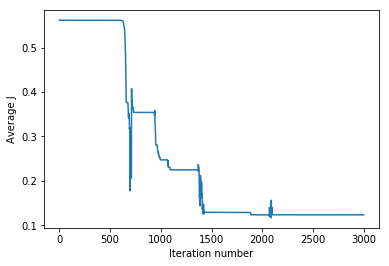

Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


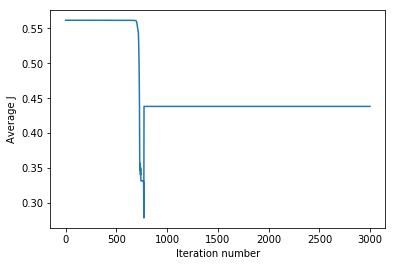

Prediction accuracy is 50.42016806722689%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


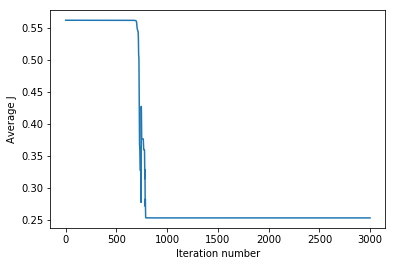

Prediction accuracy is 83.19327731092437%
[[49.99999999999999, 0.7899159663865546], [52.35776774979867, 0.8235294117647058], [54.82671687483713, 0.7899159663865546], [57.41209017233381, 0.8235294117647058], [60.11937766547103, 0.8235294117647058], [62.95432826142331, 0.8067226890756303], [65.92296195912375, 0.8067226890756303], [69.03158263269229, 0.7983193277310925], [72.28679141767074, 0.7563025210084033], [75.6955007284909, 0.8067226890756303], [79.26494893694081, 0.773109243697479], [83.00271574279998, 0.8067226890756303], [86.91673826928154, 0.8319327731092437], [91.01532791746163, 0.7563025210084033], [95.30718801548448, 0.7983193277310925], [99.8014323000226, 0.7394957983193278], [104.50760426923672, 0.7142857142857143], [109.43569744833125, 0.7983193277310925], [114.59617661073932, 0.5042016806722689], [119.99999999999996, 0.8319327731092437]]


In [266]:
lambs = np.geomspace(50, 120, 20)
res = main(1000, lambs)
print(res)

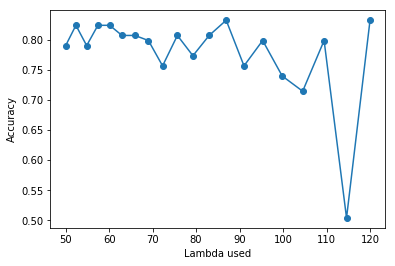

[[114.59617661073932, 0.5042016806722689], [104.50760426923672, 0.7142857142857143], [99.8014323000226, 0.7394957983193278], [72.28679141767074, 0.7563025210084033], [91.01532791746163, 0.7563025210084033], [79.26494893694081, 0.773109243697479], [49.99999999999999, 0.7899159663865546], [54.82671687483713, 0.7899159663865546], [69.03158263269229, 0.7983193277310925], [95.30718801548448, 0.7983193277310925], [109.43569744833125, 0.7983193277310925], [62.95432826142331, 0.8067226890756303], [65.92296195912375, 0.8067226890756303], [75.6955007284909, 0.8067226890756303], [83.00271574279998, 0.8067226890756303], [52.35776774979867, 0.8235294117647058], [57.41209017233381, 0.8235294117647058], [60.11937766547103, 0.8235294117647058], [86.91673826928154, 0.8319327731092437], [119.99999999999996, 0.8319327731092437]]


In [272]:
x_1000 = lambs
y_1000 = [elem[1] for elem in res]
plt.plot(x_1000,y_1000, marker='o')
plt.xlabel('Lambda used')
plt.ylabel('Accuracy')
plt.show()

sorted_res = sorted(res, key=lambda x: x[1])
print(sorted_res)
# sorted_lst_4 = sorted(res[0][1], key=lambda x: x[1])
# print(sorted_lst_4)

# sorted_lst_300 = sorted(res[1][1], key=lambda x: x[1])
# print(sorted_lst_300)

# sorted_lst_1000 = sorted(res[2][1], key=lambda x: x[1])
# print(sorted_lst_1000)

In [283]:
info = [int(elem) for elem in np.linspace(4,800,10)]
lambs = np.geomspace(0.05, 60, 20)
#res = [4,20,50,100,300,500,800]
print(info)
for i in range(len(info)):
    res.append([info[i],main(info[i], lambs)])

[4, 92, 180, 269, 357, 446, 534, 623, 711, 800]
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 84.87394957983193%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 84.03361344537815%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 78.99159663865547%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 80.67226890756302%
Starting gradient descent fo

Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 74.78991596638656%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 76.47058823529412%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 78.15126050420169%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 78.15126050420169%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 76.47058823529412%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 76.47058823529412%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 76.4705

Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 51.26050420168067%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 56.30252100840336%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 75.63025210084034%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 76.47058823529412%
Starting gradient descent for 3000

Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.57983193277311%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 49.5798

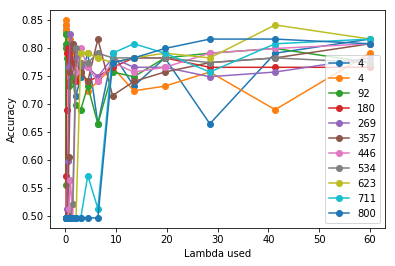

0.8235294117647058
0.8487394957983193
0.8403361344537815
0.8319327731092437
0.7899159663865546
0.8067226890756303
0.8151260504201681
0.7983193277310925
0.8151260504201681
0.7899159663865546
0.7478991596638656
0.773109243697479
0.7226890756302521
0.7394957983193278
0.7647058823529411
0.7226890756302521
0.7310924369747899
0.7563025210084033
0.6890756302521008
0.7899159663865546


In [299]:
# for elem in res:
#     print(elem)
#     print()
# print(len(res))

x = lambs

for a in res:

    y=[]
    for elem in a[1]:
        y.append(elem[1])
        #print(elem[1])
    plt.plot(x,y,marker='o', label=a[0])    

plt.xlabel('Lambda used')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

for elem in res[1][1]:
    print(elem[1])
# for lamb in lambs:
#     print(lamb)
# x = lambs
# y_4, y_300, y_1000 = [nums[1] for nums in res[0][1]], [nums[1] for nums in res[1][1]], [nums[1] for nums in res[2][1]]
# plt.plot(x,y_4,marker='o')
# plt.plot(x,y_300,marker='o')
# plt.plot(x,y_1000,marker='o')
# # plt.xticks(np.arange(min(x), max(x)+1, 5))
# plt.xlabel('Lambda used')
# plt.ylabel('Accuracy')
# plt.show()

In [305]:
res_small = []
lambs_small = np.geomspace(0.01, 1, 20)
n_neuron_3_19 = [int(num)+1 for num in np.linspace(2,18,10)] 
print(n_neuron_3_19)

for i in range(len(n_neuron_3_19)):
    res_small.append([n_neuron_3_19[i], main(n_neuron_3_19[i], lambs_small)])

[3, 4, 6, 8, 10, 11, 13, 15, 17, 19]
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 85.71428571428571%
Starting gradient descent for 3000 iterati

Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 76.4705882

Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 84.03361344537815%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 79.83193277310924%
Starting gradient descent for 3000

Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 84.87394957983193%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 74.78991596638656%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 78.99159663865547%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 81.512605

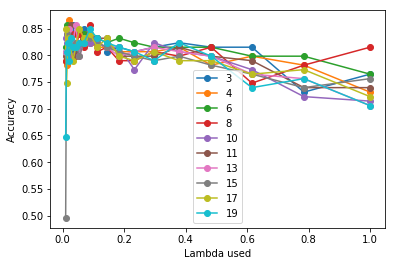

0.7899159663865546
0.7815126050420168
0.8235294117647058
0.865546218487395
0.8319327731092437
0.8235294117647058
0.8403361344537815
0.8151260504201681
0.8403361344537815
0.8235294117647058
0.8151260504201681
0.8151260504201681
0.8067226890756303
0.8067226890756303
0.8067226890756303
0.8151260504201681
0.7815126050420168
0.7983193277310925
0.7815126050420168
0.7310924369747899


In [306]:
x_small = lambs_small


for a in res_small:
    y=[]
    for elem in a:
        y.append(elem[1])
        #print(elem[1])
    plt.plot(x_small,y,marker='o', label=a[0])    

plt.xlabel('Lambda used')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

for elem in res_small[1][1]:
    print(elem[1])

In [309]:
for a in lambs_small:
    print(a)
for a in res_small:
    print("Start",a[0],"Start")
    for elem in a[1]: 
        print(elem[1])
    print("End",a[0],"End")


0.01
0.012742749857031334
0.016237767391887217
0.0206913808111479
0.026366508987303583
0.03359818286283781
0.04281332398719394
0.0545559478116852
0.06951927961775606
0.08858667904100823
0.11288378916846889
0.14384498882876628
0.18329807108324356
0.23357214690901212
0.29763514416313175
0.37926901907322497
0.4832930238571752
0.615848211066026
0.7847599703514611
1.0
Start 3 Start
0.8067226890756303
0.8151260504201681
0.8151260504201681
0.8151260504201681
0.8067226890756303
0.8571428571428571
0.8067226890756303
0.8151260504201681
0.8487394957983193
0.8235294117647058
0.8319327731092437
0.8067226890756303
0.8151260504201681
0.8067226890756303
0.8151260504201681
0.8235294117647058
0.8151260504201681
0.8151260504201681
0.7310924369747899
0.7647058823529411
End 3 End
Start 4 Start
0.7899159663865546
0.7815126050420168
0.8235294117647058
0.865546218487395
0.8319327731092437
0.8235294117647058
0.8403361344537815
0.8151260504201681
0.8403361344537815
0.8235294117647058
0.8151260504201681
0.815126

In [317]:
# print training accuracy for neuron # = 4, 4 seems to be a good choice with lambda = 0.2, empirically, also suggested by 
# sqrt(n*m) heuristics rule of thumb
n_iter = [i for i in range(1000, 10001, 1000)]
res_4 = {}
lambs_4 = np.geomspace(0.01, 1, 20)

for num in n_iter:
    res_4[num] = []

    
for num in n_iter:
    
    acc_tr, acc_test = main(4, lambs_4, num)

    res_4[num].append(acc_tr)
    res_4[num].append(acc_test)

Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 57.865168539325836%
Prediction accuracy is 72.26890756302521%
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 58.42696629213483%
Prediction accuracy is 67.22689075630252%
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 65.73033707865169%
Prediction accuracy is 78.15126050420169%
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 63.48314606741573%
Prediction accuracy is 73.94957983193278%
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 74.71910112359551%
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 72.47191011235955%
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Prediction accuracy is 80.8988764

Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 83.70786516853933%
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 84.8314606741573%
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 87.64044943820225%
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 88.76404494382022%
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
Prediction accuracy is 88.20224719101124%
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000

Iteration 1000 of 5000
Iteration 2000 of 5000
Iteration 3000 of 5000
Iteration 4000 of 5000
Prediction accuracy is 82.58426966292134%
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 1000 of 5000
Iteration 2000 of 5000
Iteration 3000 of 5000
Iteration 4000 of 5000
Prediction accuracy is 86.51685393258427%
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 1000 of 5000
Iteration 2000 of 5000
Iteration 3000 of 5000
Iteration 4000 of 5000
Prediction accuracy is 85.95505617977528%
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 1000 of 5000
Iteration 2000 of 5000
Iteration 3000 of 5000
Iteration 4000 of 5000
Prediction accuracy is 88.76404494382022%
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 1000 of 5000
Iteration

Iteration 2000 of 6000
Iteration 3000 of 6000
Iteration 4000 of 6000
Iteration 5000 of 6000
Prediction accuracy is 94.9438202247191%
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 7000 iterations
Iteration 0 of 7000
Iteration 1000 of 7000
Iteration 2000 of 7000
Iteration 3000 of 7000
Iteration 4000 of 7000
Iteration 5000 of 7000
Iteration 6000 of 7000
Prediction accuracy is 72.47191011235955%
Prediction accuracy is 82.35294117647058%
Starting gradient descent for 7000 iterations
Iteration 0 of 7000
Iteration 1000 of 7000
Iteration 2000 of 7000
Iteration 3000 of 7000
Iteration 4000 of 7000
Iteration 5000 of 7000
Iteration 6000 of 7000
Prediction accuracy is 75.84269662921348%
Prediction accuracy is 79.83193277310924%
Starting gradient descent for 7000 iterations
Iteration 0 of 7000
Iteration 1000 of 7000
Iteration 2000 of 7000
Iteration 3000 of 7000
Iteration 4000 of 7000
Iteration 5000 of 7000
Iteration 6000 of 7000
Prediction accuracy is 78.08988764044943%
Pred

Iteration 3000 of 8000
Iteration 4000 of 8000
Iteration 5000 of 8000
Iteration 6000 of 8000
Iteration 7000 of 8000
Prediction accuracy is 87.07865168539325%
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 8000 iterations
Iteration 0 of 8000
Iteration 1000 of 8000
Iteration 2000 of 8000
Iteration 3000 of 8000
Iteration 4000 of 8000
Iteration 5000 of 8000
Iteration 6000 of 8000
Iteration 7000 of 8000
Prediction accuracy is 87.07865168539325%
Prediction accuracy is 83.19327731092437%
Starting gradient descent for 8000 iterations
Iteration 0 of 8000
Iteration 1000 of 8000
Iteration 2000 of 8000
Iteration 3000 of 8000
Iteration 4000 of 8000
Iteration 5000 of 8000
Iteration 6000 of 8000
Iteration 7000 of 8000
Prediction accuracy is 88.76404494382022%
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 8000 iterations
Iteration 0 of 8000
Iteration 1000 of 8000
Iteration 2000 of 8000
Iteration 3000 of 8000
Iteration 4000 of 8000
Iteration 5000 of 8000

Iteration 1000 of 9000
Iteration 2000 of 9000
Iteration 3000 of 9000
Iteration 4000 of 9000
Iteration 5000 of 9000
Iteration 6000 of 9000
Iteration 7000 of 9000
Iteration 8000 of 9000
Prediction accuracy is 92.69662921348315%
Prediction accuracy is 81.5126050420168%
Starting gradient descent for 9000 iterations
Iteration 0 of 9000
Iteration 1000 of 9000
Iteration 2000 of 9000
Iteration 3000 of 9000
Iteration 4000 of 9000
Iteration 5000 of 9000
Iteration 6000 of 9000
Iteration 7000 of 9000
Iteration 8000 of 9000
Prediction accuracy is 91.57303370786516%
Prediction accuracy is 80.67226890756302%
Starting gradient descent for 9000 iterations
Iteration 0 of 9000
Iteration 1000 of 9000
Iteration 2000 of 9000
Iteration 3000 of 9000
Iteration 4000 of 9000
Iteration 5000 of 9000
Iteration 6000 of 9000
Iteration 7000 of 9000
Iteration 8000 of 9000
Prediction accuracy is 94.3820224719101%
Prediction accuracy is 78.15126050420169%
Starting gradient descent for 9000 iterations
Iteration 0 of 9000


Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000
Prediction accuracy is 95.50561797752809%
Prediction accuracy is 72.26890756302521%
Starting gradient descent for 10000 iterations
Iteration 0 of 10000
Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000
Prediction accuracy is 95.50561797752809%
Prediction accuracy is 77.31092436974791%
Starting gradient descent for 10000 iterations
Iteration 0 of 10000
Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000
Prediction accuracy is 95.50561797752809%
Predic

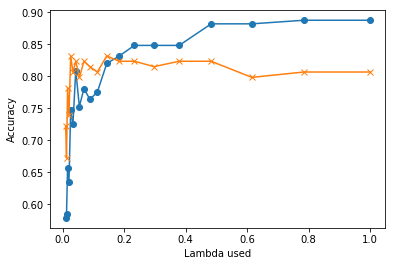

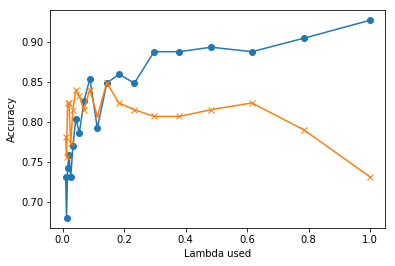

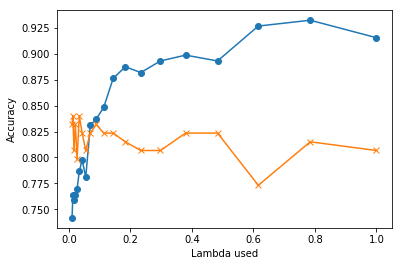

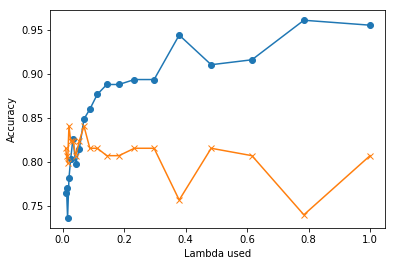

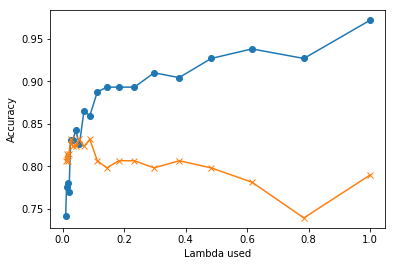

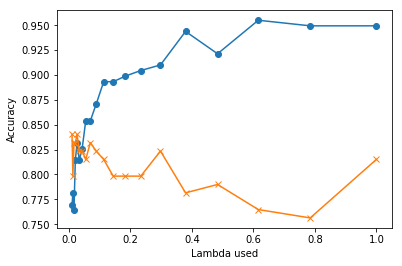

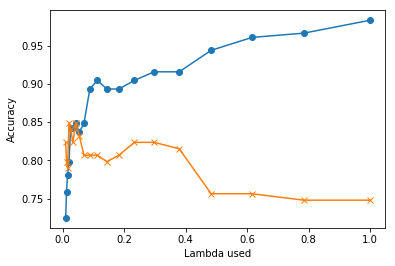

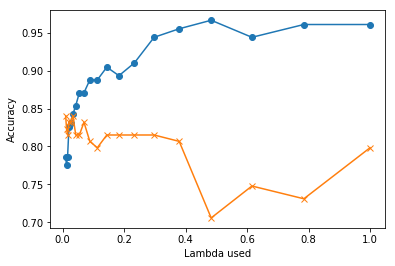

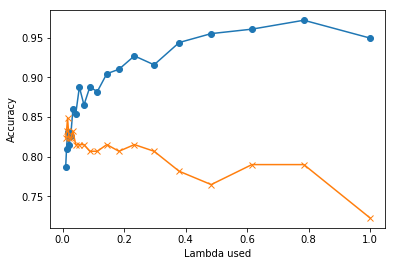

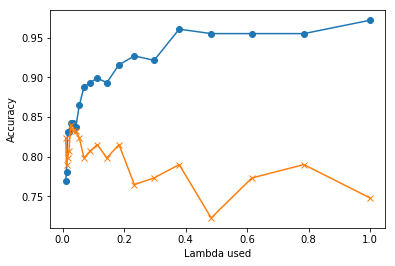

In [330]:
# for lamb in lambs_4:
#     print(lamb)


for iters in res_4:
#     print("Start",iters)
#     print("Training acc:")
    tr_lst, test_lst = [],[]
    for acc_trs in res_4[iters][0]:
        tr_lst.append(acc_trs[1])
    #print("Test acc:")
    for acc_test in res_4[iters][1]:
        test_lst.append(acc_test[1])
        
    plt.plot(lambs_4,tr_lst,marker='o', label="training_acc")
    plt.plot(lambs_4,test_lst,marker='x', label="test_acc")
    plt.xlabel('Lambda used')
    plt.ylabel('Accuracy')
    plt.show()
    #print("End",iters)
    print()
#print(res_4[1000][0])

In [335]:
res_4_small = []
lambs_4_small = np.geomspace(0.001, 1, 20)
print(lambs_4_small)
# tr_4_002, test_4_002 = main(4, [0.0206913808111479], 3000)
# print(tr_4_002, test_4_002)

[0.001      0.00143845 0.00206914 0.00297635 0.00428133 0.00615848
 0.00885867 0.01274275 0.01832981 0.02636651 0.0379269  0.05455595
 0.078476   0.11288379 0.16237767 0.23357215 0.33598183 0.48329302
 0.6951928  1.        ]
